In [44]:
import numpy as np
import matplotlib.pyplot as plt
import random
import scipy.io as sio
import pandas as pd
from shapely.geometry import  LineString
from mat4py import loadmat


In [45]:
#Data import
mat_contents = sio.loadmat('P_R1_without_gaps.mat')
oct_a = mat_contents['P_sq']

oct_b = np.loadtxt('P_R2_without.txt')

""" mat_contents_2 = sio.loadmat('P_R2_without_gaps.mat')
oct_b = mat_contents_2['P_sq'] """

data_1 = np.loadtxt('z1.txt')
data_2 = np.loadtxt('z2.txt')
time_1 = np.loadtxt('t1.txt')
time_2 = np.loadtxt('t2.txt')

In [46]:
#Rocket 1
z_1 = np.zeros((2, len(time_1)))
z_1[0, :] = data_1[:, 0] 
z_1[1, :] = data_1[:, 1] 

bar_1 = data_1[:, 0]
accel_1 = data_1[:, 1]
#Rocket 2
z_2 = np.zeros((2, len(time_2)))
z_2[0, :] = data_2[:, 0] 
z_2[1, :] = data_2[:, 1] 
bar_2 = data_2[:, 0]
accel_2 = data_2[:, 1]

size = len(time_1)

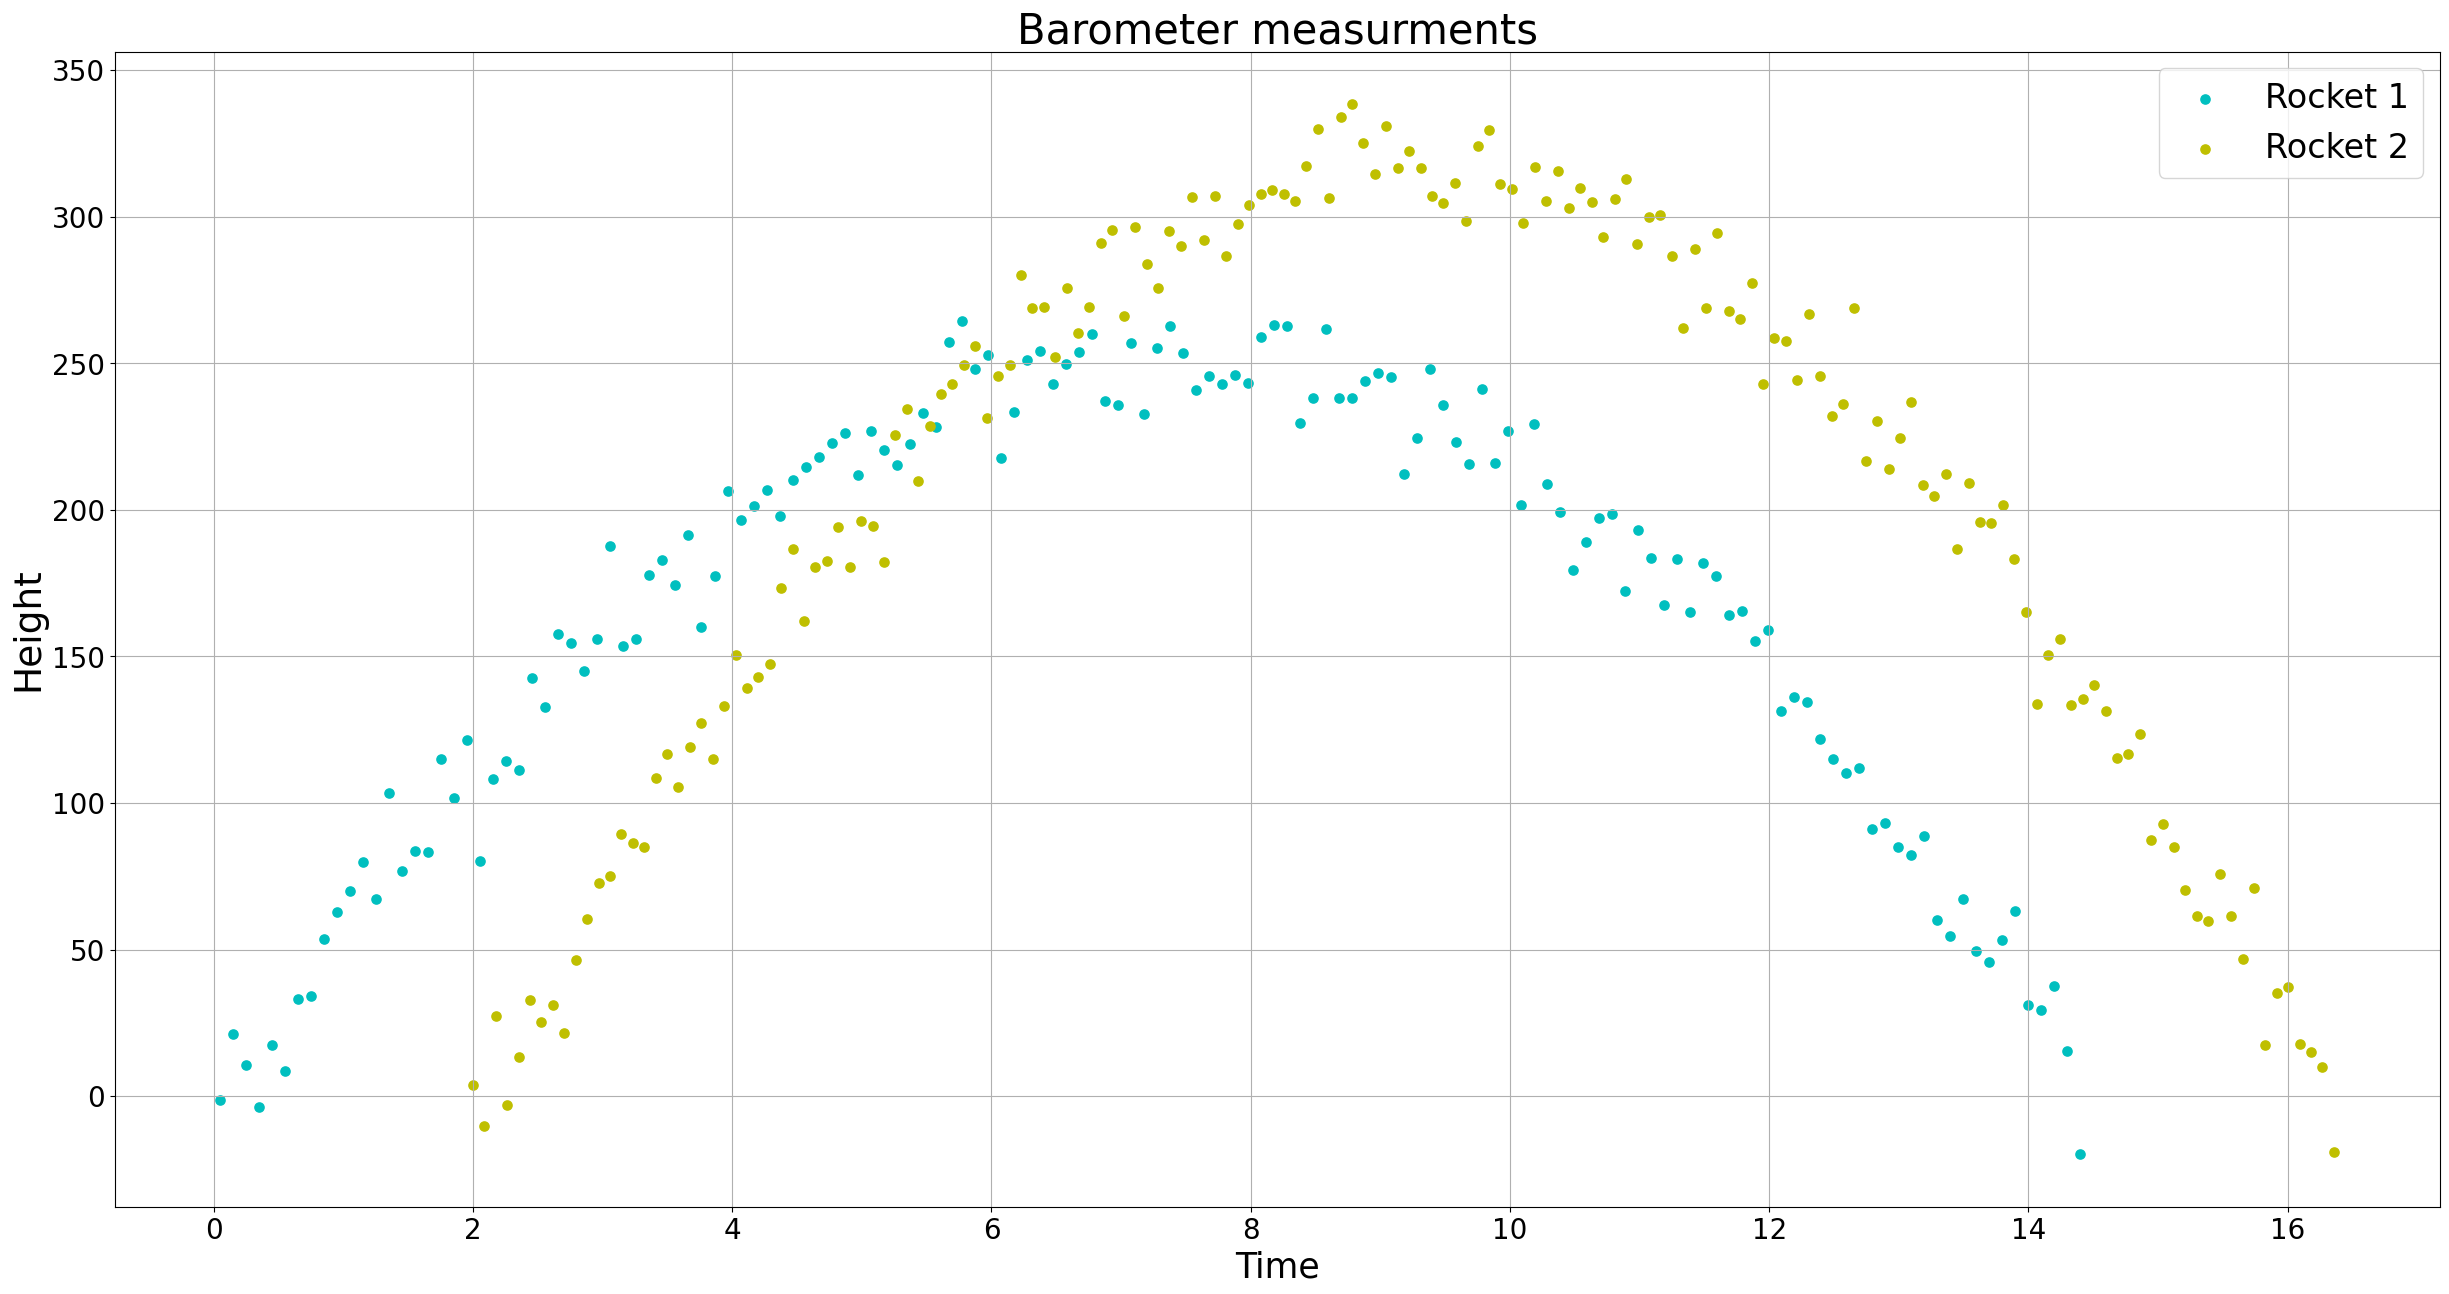

In [47]:
#Plotting data (barometer)
from matplotlib import markers

fig, ax = plt.subplots(figsize=(30,15))
ax.set_title("Barometer measurments", fontsize = 30)
ax.set_ylabel("Height", fontsize = 27)
ax.set_xlabel("Time", fontsize = 25)
ax.scatter(time_1, bar_1, c = 'c', s = 44, label = "Rocket 1")
ax.scatter(time_2, bar_2, c = 'y', s = 44, label = "Rocket 2")

ax.tick_params(labelsize = 20)
ax.legend(fontsize = 24)
plt.grid()

In [48]:
""" #Plotting data (accelerometer)

fig, ax = plt.subplots(figsize=(30,20))
ax.set_title("Accelerometer measurments", fontsize = 30)
ax.set_ylabel("Value", fontsize = 25)
ax.set_xlabel("Observations", fontsize = 25)
ax.plot(time_1, accel_1, 'y.', markersize = 10, label = "Rocket 1")
ax.plot(time_2, accel_2, 'b.', markersize = 10, label = "Rocket 2")

ax.tick_params(labelsize = 22)
ax.legend(fontsize = 22) """

' #Plotting data (accelerometer)\n\nfig, ax = plt.subplots(figsize=(30,20))\nax.set_title("Accelerometer measurments", fontsize = 30)\nax.set_ylabel("Value", fontsize = 25)\nax.set_xlabel("Observations", fontsize = 25)\nax.plot(time_1, accel_1, \'y.\', markersize = 10, label = "Rocket 1")\nax.plot(time_2, accel_2, \'b.\', markersize = 10, label = "Rocket 2")\n\nax.tick_params(labelsize = 22)\nax.legend(fontsize = 22) '

In [49]:
#Kalman filter. Rocket 1. Barometer
#Initial filtered state matrix
X_init_1 = np.array([[0], [0], [160]])
P_init_1 = np.eye(3)
for n in range(3):
    P_init_1[n, n] = 100

Meas_1 = len(bar_1)
T_1 = time_1[1] - time_1[0]
#Transition matrix
Phi_1 = np.eye(3)
Phi_1[0, 1] = T_1
Phi_1[1, 2] = T_1
Phi_1[0, 2] = T_1 ** 2 / 2

#Measurments
sigma_s = 12**2
sigma_a = 0.09 ** 2
H = np.array([[1, 0, 0], [0, 0, 1]])
#Covariance matrix 𝑅 of measurements noise
R = np.array([[sigma_s, 0], [0, sigma_a]])
I = np.eye(3)

In [50]:

def Kalman(X_init, P_init, Phi, size_, z_):
    #Filterd position
    X_pred = np.zeros((3, size_))
    P_pred = np.zeros((3, 3, size_))

    X_filt = np.zeros((3, size_))
    P_filt = np.zeros((3, 3, size_))
    
    K_ = np.zeros((3, 2, size_))

    X_filt[:, 0] = X_init[:, 0]
    print(X_filt[2, 0])
    P_filt[:, :, 0] = P_init

    H = np.array([[1, 0, 0], [0, 0, 1]])
    #Covariance matrix 𝑅 of measurements noise
    R = np.array([[sigma_s, 0], [0, sigma_a]])
    I = np.eye(3)

    for n in range(1, size_):
        if np.isnan(z_[0, n]) == True:
            X_pred[:, n] = (Phi.dot(X_filt[:, n-1].reshape(3, 1))).reshape(-1)
            P_pred[:, :, n] = (Phi.dot(P_filt[:, :, n-1])).dot(Phi.T) + I

            X_filt[:, n] = X_pred[:, n]
            P_filt[:, :, n] = P_pred[:, :, n]
        else:
            X_pred[:, n] = (Phi.dot(X_filt[:, n-1].reshape(3, 1))).reshape(-1)
            P_pred[:, :, n] = (Phi.dot(P_filt[:, :, n-1])).dot(Phi.T)

            K_[:, :, n] = np.dot(P_pred[:, :, n].dot(H.T), np.linalg.inv(H.dot(P_pred[:, :, n]).dot(H.T) + R))
            P_filt[:, :, n] = (I - K_[:, :, n].dot(H)).dot(P_pred[:, :, n])
            X_filt[:, n] = (X_pred[:, n].reshape(3, 1) + K_[:, :, n].dot(z_[:, n].reshape(2, 1) - H.dot(X_pred[:, n].reshape(3, 1)))).reshape(-1)

    return X_pred, P_pred, X_filt, P_filt, K_

In [51]:
#Kalman backword
def Kalman_backward(X_filt, P_filt, P_pred, phi, n):
    X_back = np.zeros((3, n))
    X_back[:, -1] = X_filt[:, -1]
    P_back = np.zeros((3, 3, n))
    P_back[:, :, -1] = P_filt[:, :, -1]
    A_back = np.zeros((3, 3, n))

    for i in reversed(range(n - 1)):
        A_back[:, :, i] = P_filt[:, :, i].dot(phi.T).dot(np.linalg.inv(P_pred[:, :, i + 1]))
        X_back[:, i] = X_filt[:, i] + A_back[:, :, i].dot(X_back[:, i + 1] - phi.dot(X_filt[:, i]))
        P_back[:, :, i] = P_filt[:, :, i] + A_back[:, :, i].dot(P_back[:, :, i + 1] - P_pred[:, :, i + 1]).dot(A_back[:, :, i].T)

    return X_back, P_back

In [52]:
X_pred_1, P_pred_1, X_filt_1, P_filt_1, K_1 = Kalman(X_init_1, P_init_1, Phi_1, Meas_1, z_1)


160.0


In [53]:
""" fig, ax = plt.subplots(figsize=(15,7))
ax.set_title("Kalman filtration of acceleration (1 Rocket)", fontsize = 16)
ax.set_ylabel("Position", fontsize = 14)
ax.set_xlabel("Observations", fontsize = 14)
#ax.plot(Z_meas[0, :], 'b', alpha = 0.6, linewidth = 2, label = "Measurments")
ax.plot(z_1[0, :], '.', linewidth=2, label = "True trajectory", c = 'y')
ax.plot(X_filt_1[0, :], 'r', linewidth = 2, label = "Kalman filtration")

ax.tick_params(labelsize = 14)
ax.legend(fontsize = 12)
ax.grid()
plt.show() """

' fig, ax = plt.subplots(figsize=(15,7))\nax.set_title("Kalman filtration of acceleration (1 Rocket)", fontsize = 16)\nax.set_ylabel("Position", fontsize = 14)\nax.set_xlabel("Observations", fontsize = 14)\n#ax.plot(Z_meas[0, :], \'b\', alpha = 0.6, linewidth = 2, label = "Measurments")\nax.plot(z_1[0, :], \'.\', linewidth=2, label = "True trajectory", c = \'y\')\nax.plot(X_filt_1[0, :], \'r\', linewidth = 2, label = "Kalman filtration")\n\nax.tick_params(labelsize = 14)\nax.legend(fontsize = 12)\nax.grid()\nplt.show() '

In [54]:
#Backward Rocket 1
X_back_1, P_back_1 = Kalman_backward(X_filt_1, P_filt_1, P_pred_1, Phi_1, Meas_1)

np.savetxt ('P_gaps_rocket_1.txt', P_back_1[0, 0, :])


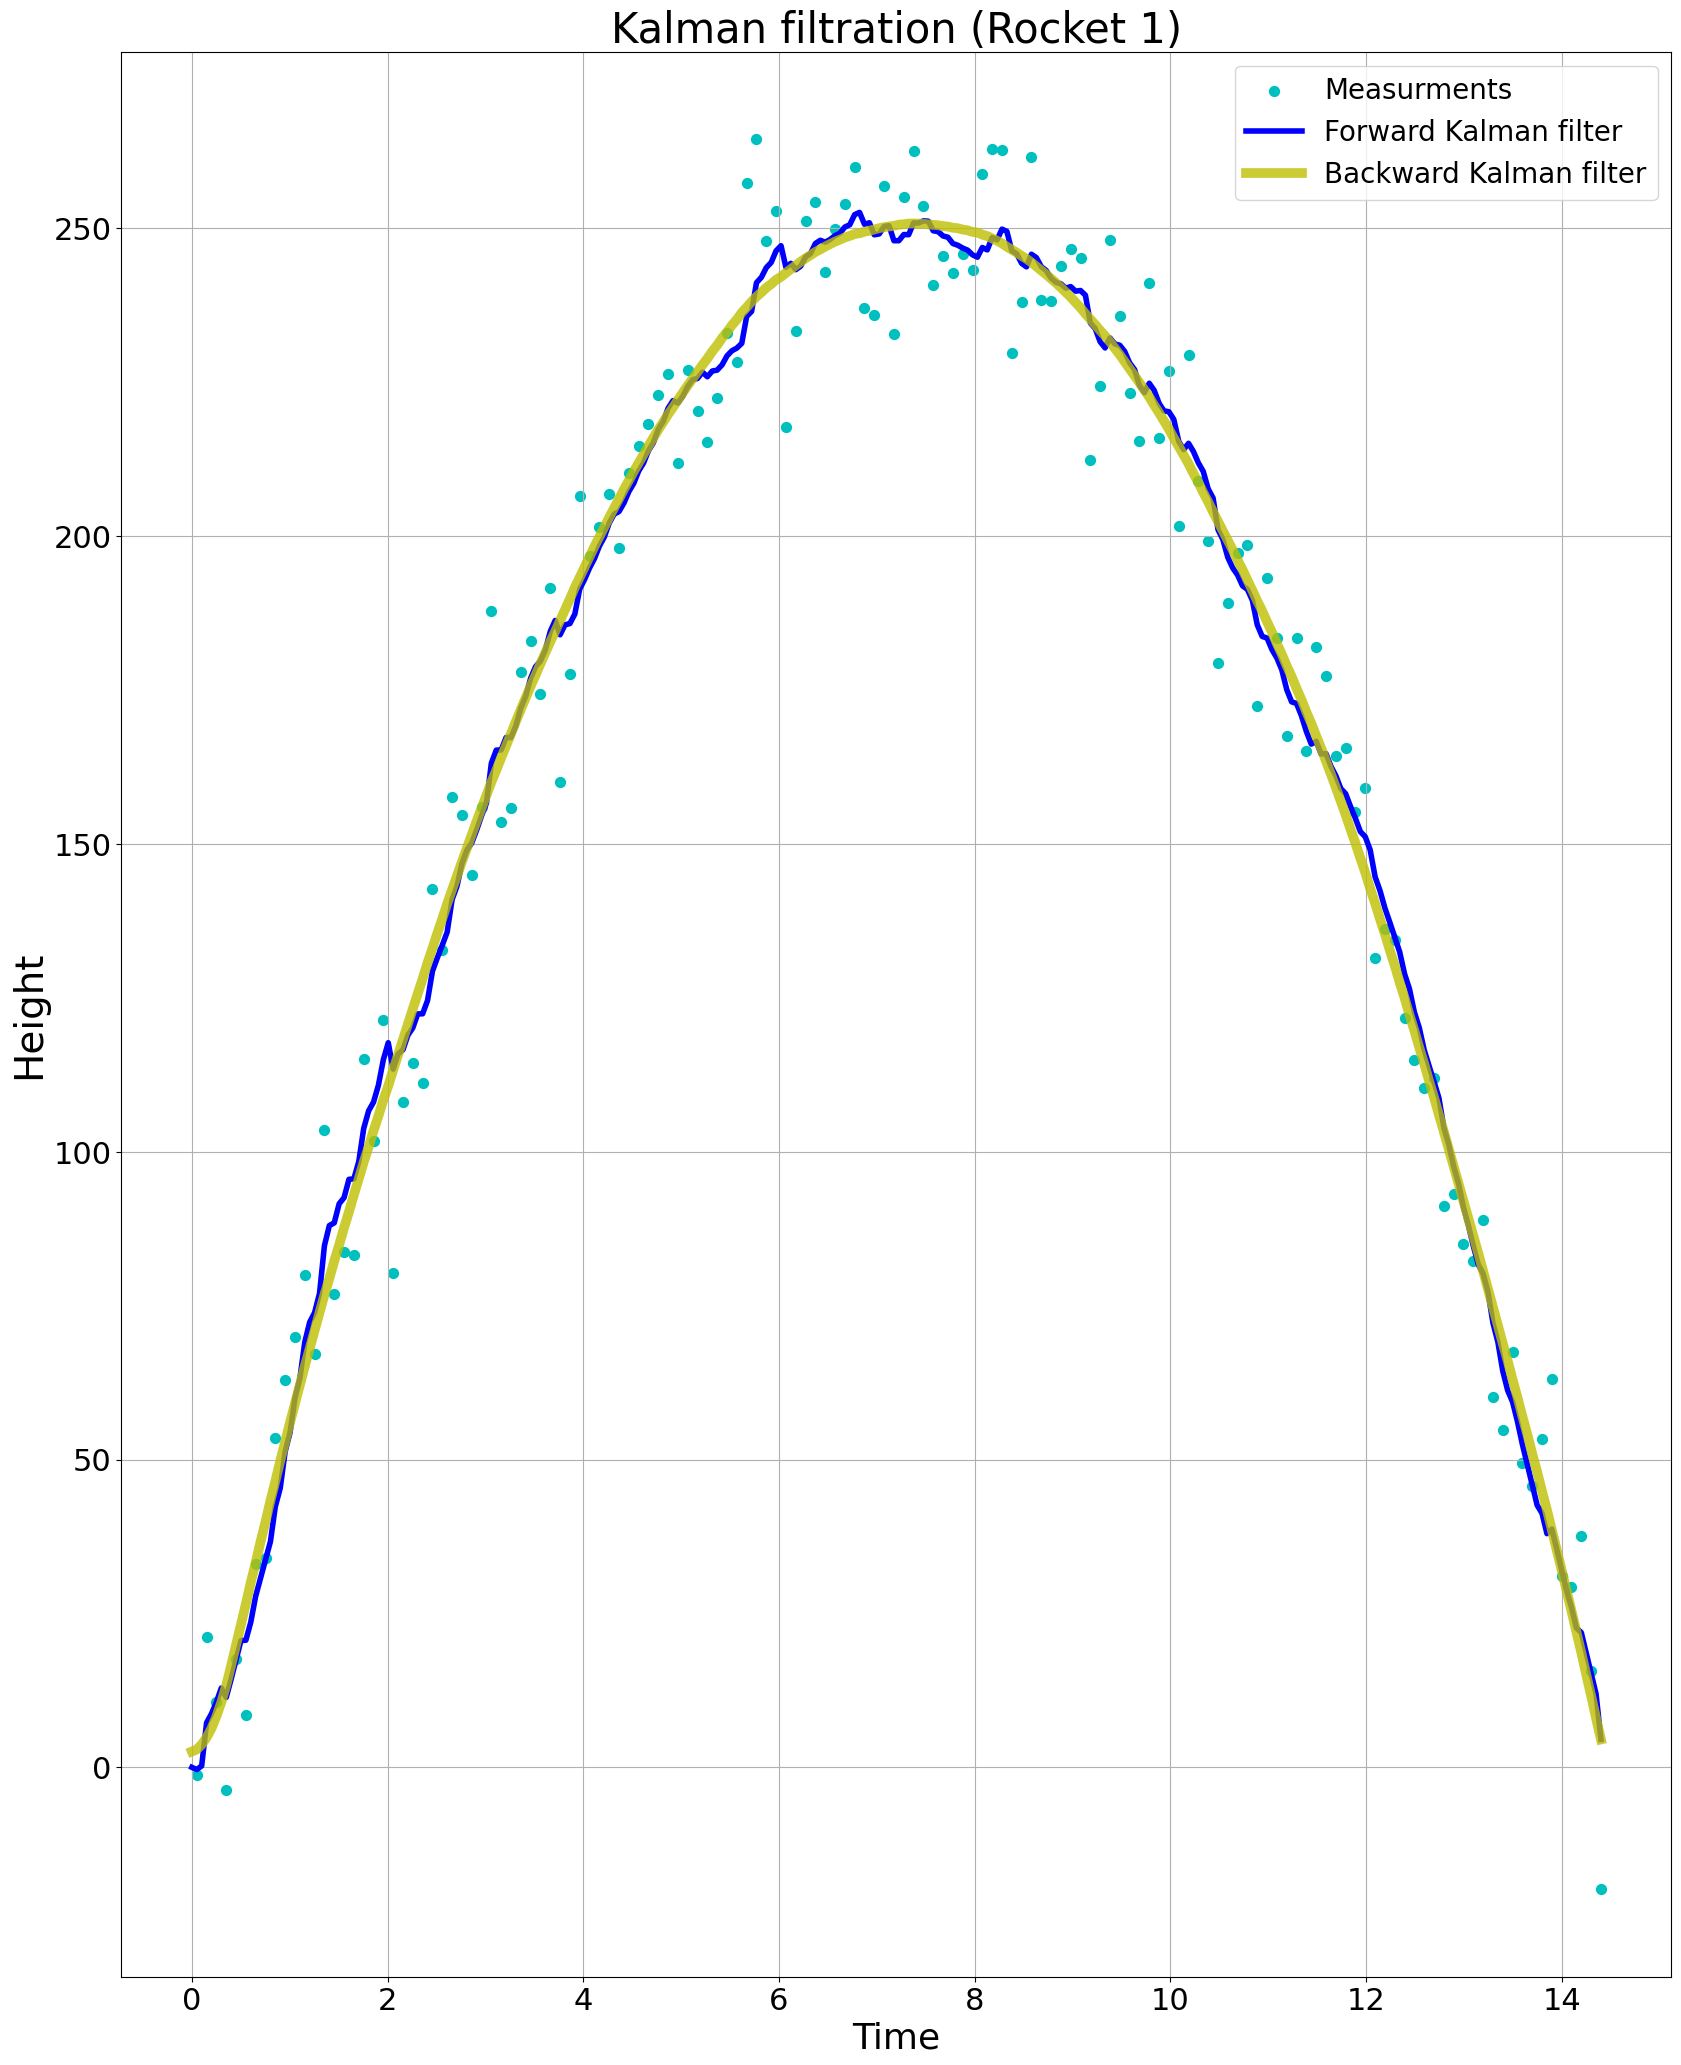

In [55]:
fig, ax = plt.subplots(figsize=(20,25))
ax.set_title("Kalman filtration (Rocket 1)", fontsize = 30)
ax.set_ylabel("Height", fontsize = 28)
ax.set_xlabel("Time", fontsize = 26)
#ax.plot(Z_meas[0, :], 'b', alpha = 0.6, linewidth = 2, label = "Measurments")
ax.scatter(time_1, bar_1, c = 'c', s = 50, label = "Measurments")
ax.plot(time_1, X_filt_1[0, :], 'b', linewidth = 4, label = "Forward Kalman filter")

ax.plot(time_1, X_back_1[0, :], 'y', linewidth = 7, alpha = 0.8, label = "Backward Kalman filter")
#ax.plot(time_2, X_filt_2[0, :], 'b', linewidth = 2, label = "Kalman filtration (2 rocket)")

ax.tick_params(labelsize = 22)
ax.legend(fontsize = 20)
ax.grid()
plt.show()

In [56]:
#Kalman filter. Rocket 2. Barometer
#Initial filtered state matrix
X_init_2 = np.array([[0], [0], [180]])

P_init_2 = np.eye(3)
for n in range(3):
    P_init_2[n, n] = 100

Meas_2 = len(bar_2)
T_2 = time_2[1] - time_2[0]
#Transition matrix
Phi_2 = np.eye(3)
Phi_2[0, 1] = T_2
Phi_2[1, 2] = T_2
Phi_2[0, 2] = T_2 ** 2 / 2

#Measurments
sigma_s = 12**2
sigma_a = 0.09 ** 2
H = np.array([[1, 0, 0], [0, 0, 1]])
#Covariance matrix 𝑅 of measurements noise
R = np.array([[sigma_s, 0], [0, sigma_a]])
I = np.eye(3)

In [57]:
X_pred_2, P_pred_2, X_filt_2, P_filt_2, K_2 = Kalman(X_init_2, P_init_2, Phi_2, Meas_2, z_2)


180.0


In [58]:
""" fig, ax = plt.subplots(figsize=(15,7))
ax.set_title("Kalman filtration of acceleration (2 Rocket)", fontsize = 16)
ax.set_ylabel("Position", fontsize = 14)
ax.set_xlabel("Observations", fontsize = 14)
#ax.plot(Z_meas[0, :], 'b', alpha = 0.6, linewidth = 2, label = "Measurments")
ax.plot(z_2[0, :], '.', linewidth=2, label = "True trajectory", c = 'y')
ax.plot(X_filt_2[0, :], 'r', linewidth = 2, label = "Kalman filtration")

ax.tick_params(labelsize = 14)
ax.legend(fontsize = 12)
ax.grid()
plt.show() """

' fig, ax = plt.subplots(figsize=(15,7))\nax.set_title("Kalman filtration of acceleration (2 Rocket)", fontsize = 16)\nax.set_ylabel("Position", fontsize = 14)\nax.set_xlabel("Observations", fontsize = 14)\n#ax.plot(Z_meas[0, :], \'b\', alpha = 0.6, linewidth = 2, label = "Measurments")\nax.plot(z_2[0, :], \'.\', linewidth=2, label = "True trajectory", c = \'y\')\nax.plot(X_filt_2[0, :], \'r\', linewidth = 2, label = "Kalman filtration")\n\nax.tick_params(labelsize = 14)\nax.legend(fontsize = 12)\nax.grid()\nplt.show() '

In [59]:
#Backward Rocket 2
X_back_2, P_back_2 = Kalman_backward(X_filt_2, P_filt_2, P_pred_2, Phi_2, Meas_2)
np.savetxt ('P_gaps_rocket_2.txt', P_back_2[0, 0, :])


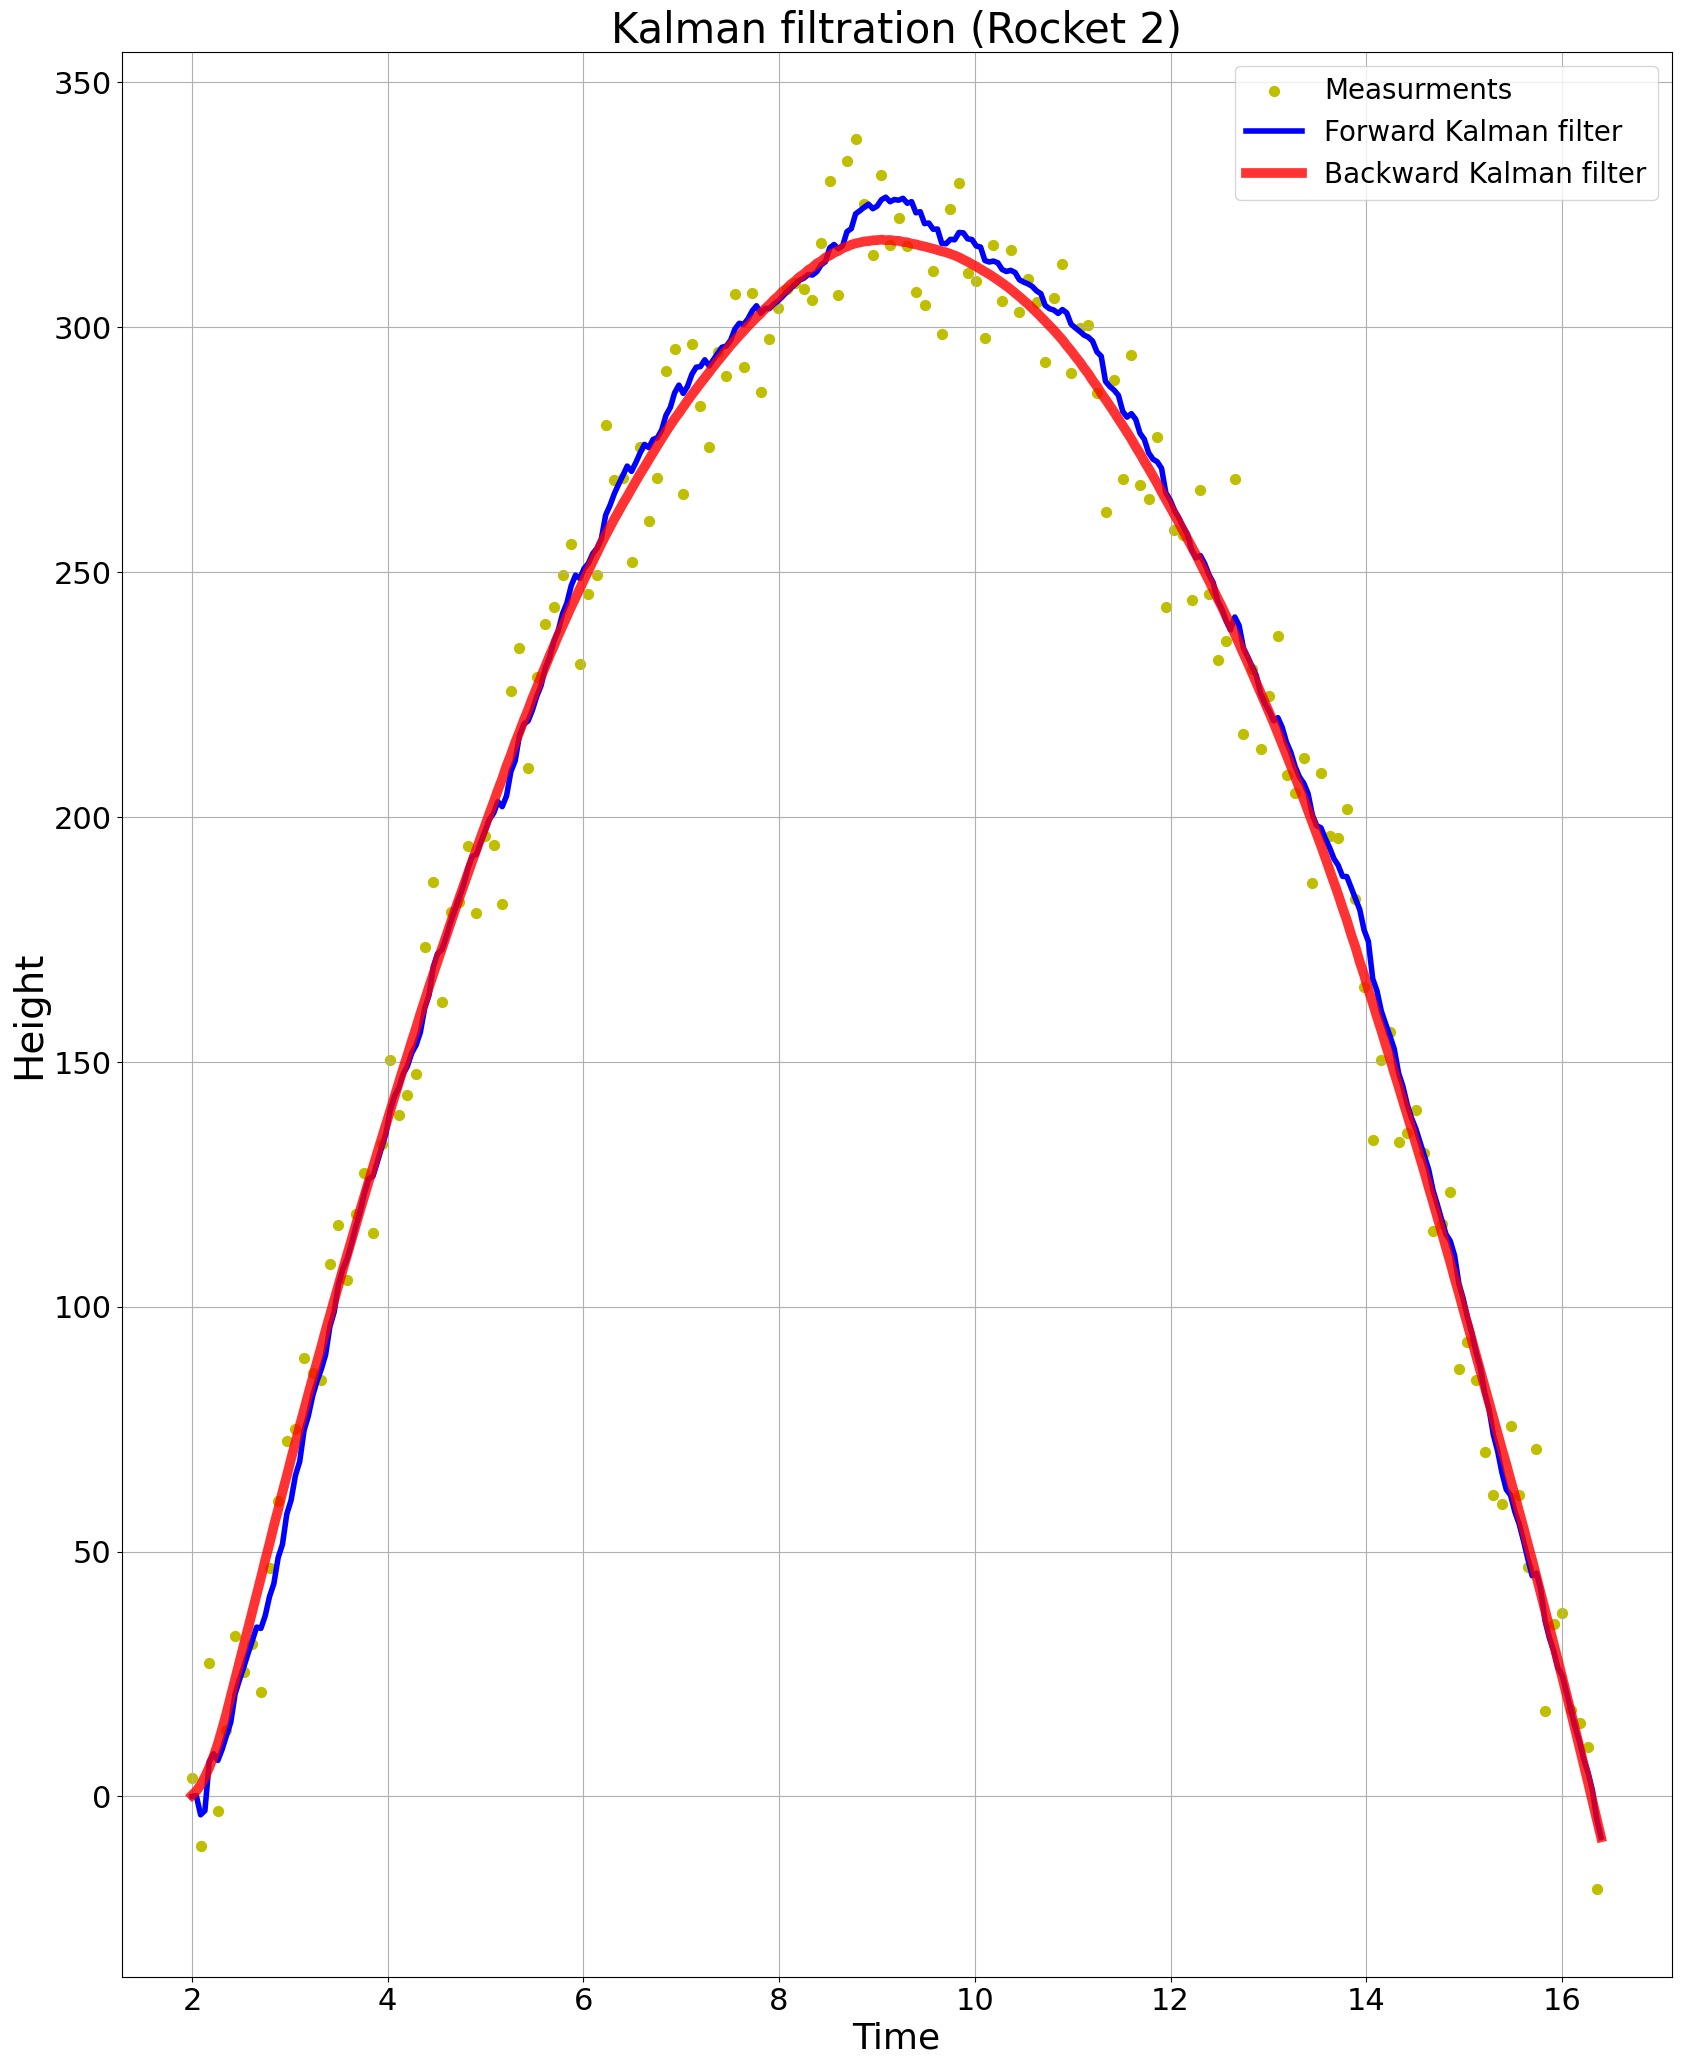

In [60]:
fig, ax = plt.subplots(figsize=(20,25))
ax.set_title("Kalman filtration (Rocket 2)", fontsize = 30)
ax.set_ylabel("Height", fontsize = 28)
ax.set_xlabel("Time", fontsize = 26)
#ax.plot(Z_meas[0, :], 'b', alpha = 0.6, linewidth = 2, label = "Measurments")
ax.scatter(time_2, bar_2, c = 'y', s = 50, label = "Measurments")
ax.plot(time_2, X_filt_2[0, :], 'b', linewidth = 4, label = "Forward Kalman filter")

ax.plot(time_2, X_back_2[0, :], 'r', linewidth = 7, alpha = 0.8, label = "Backward Kalman filter")
#ax.plot(time_2, X_filt_2[0, :], 'b', linewidth = 2, label = "Kalman filtration (2 rocket)")

ax.tick_params(labelsize = 22)
ax.legend(fontsize = 20)
ax.grid()
plt.show()

In [61]:
""" fig, ax = plt.subplots(figsize=(15,7))
ax.set_title("Kalman filtration of acceleration (2 Rocket)", fontsize = 16)
ax.set_ylabel("Position", fontsize = 14)
ax.set_xlabel("Observations", fontsize = 14)
#ax.plot(Z_meas[0, :], 'b', alpha = 0.6, linewidth = 2, label = "Measurments")
ax.plot(time_2, z_2[0, :], 'g.', linewidth=2, label = "Measured (2 rocket)")
ax.plot(time_2, X_filt_2[0, :], 'b', linewidth = 2, label = "Kalman filtration (2 rocket)")
ax.plot(time_2, X_back_2[0, :], 'y', linewidth=2, label = "Backward Kalman (2 rocket)")

ax.tick_params(labelsize = 14)
ax.legend(fontsize = 12)
ax.grid()
plt.show() """

' fig, ax = plt.subplots(figsize=(15,7))\nax.set_title("Kalman filtration of acceleration (2 Rocket)", fontsize = 16)\nax.set_ylabel("Position", fontsize = 14)\nax.set_xlabel("Observations", fontsize = 14)\n#ax.plot(Z_meas[0, :], \'b\', alpha = 0.6, linewidth = 2, label = "Measurments")\nax.plot(time_2, z_2[0, :], \'g.\', linewidth=2, label = "Measured (2 rocket)")\nax.plot(time_2, X_filt_2[0, :], \'b\', linewidth = 2, label = "Kalman filtration (2 rocket)")\nax.plot(time_2, X_back_2[0, :], \'y\', linewidth=2, label = "Backward Kalman (2 rocket)")\n\nax.tick_params(labelsize = 14)\nax.legend(fontsize = 12)\nax.grid()\nplt.show() '

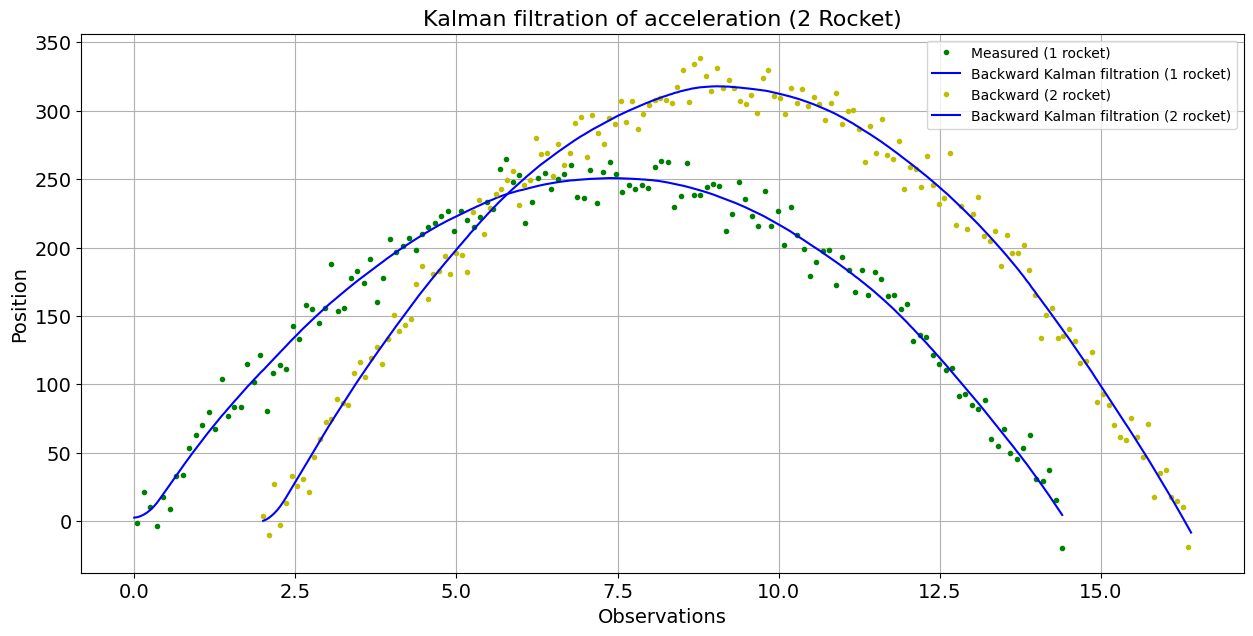

In [62]:
fig, ax = plt.subplots(figsize=(15,7))
ax.set_title("Kalman filtration of acceleration (2 Rocket)", fontsize = 16)
ax.set_ylabel("Position", fontsize = 14)
ax.set_xlabel("Observations", fontsize = 14)
#ax.plot(Z_meas[0, :], 'b', alpha = 0.6, linewidth = 2, label = "Measurments")
ax.plot(time_1, z_1[0, :], 'g.', linewidth=2, label = "Measured (1 rocket)")
#ax.plot(time_1, X_filt_1[0, :], 'r', linewidth = 2, label = "Kalman filtration (1 rocket)")
ax.plot(time_1, X_back_1[0, :], 'b', linewidth = 1.5, label = "Backward Kalman filtration (1 rocket)")

ax.plot(time_2, z_2[0, :], 'y.', linewidth=2, label = "Backward (2 rocket)")
#ax.plot(time_2, X_filt_2[0, :], 'b', linewidth = 2, label = "Kalman filtration (2 rocket)")
ax.plot(time_2, X_back_2[0, :], 'b', linewidth = 1.5, label = "Backward Kalman filtration (2 rocket)")

ax.tick_params(labelsize = 14)
ax.legend(fontsize = 10)
ax.grid()
plt.show()

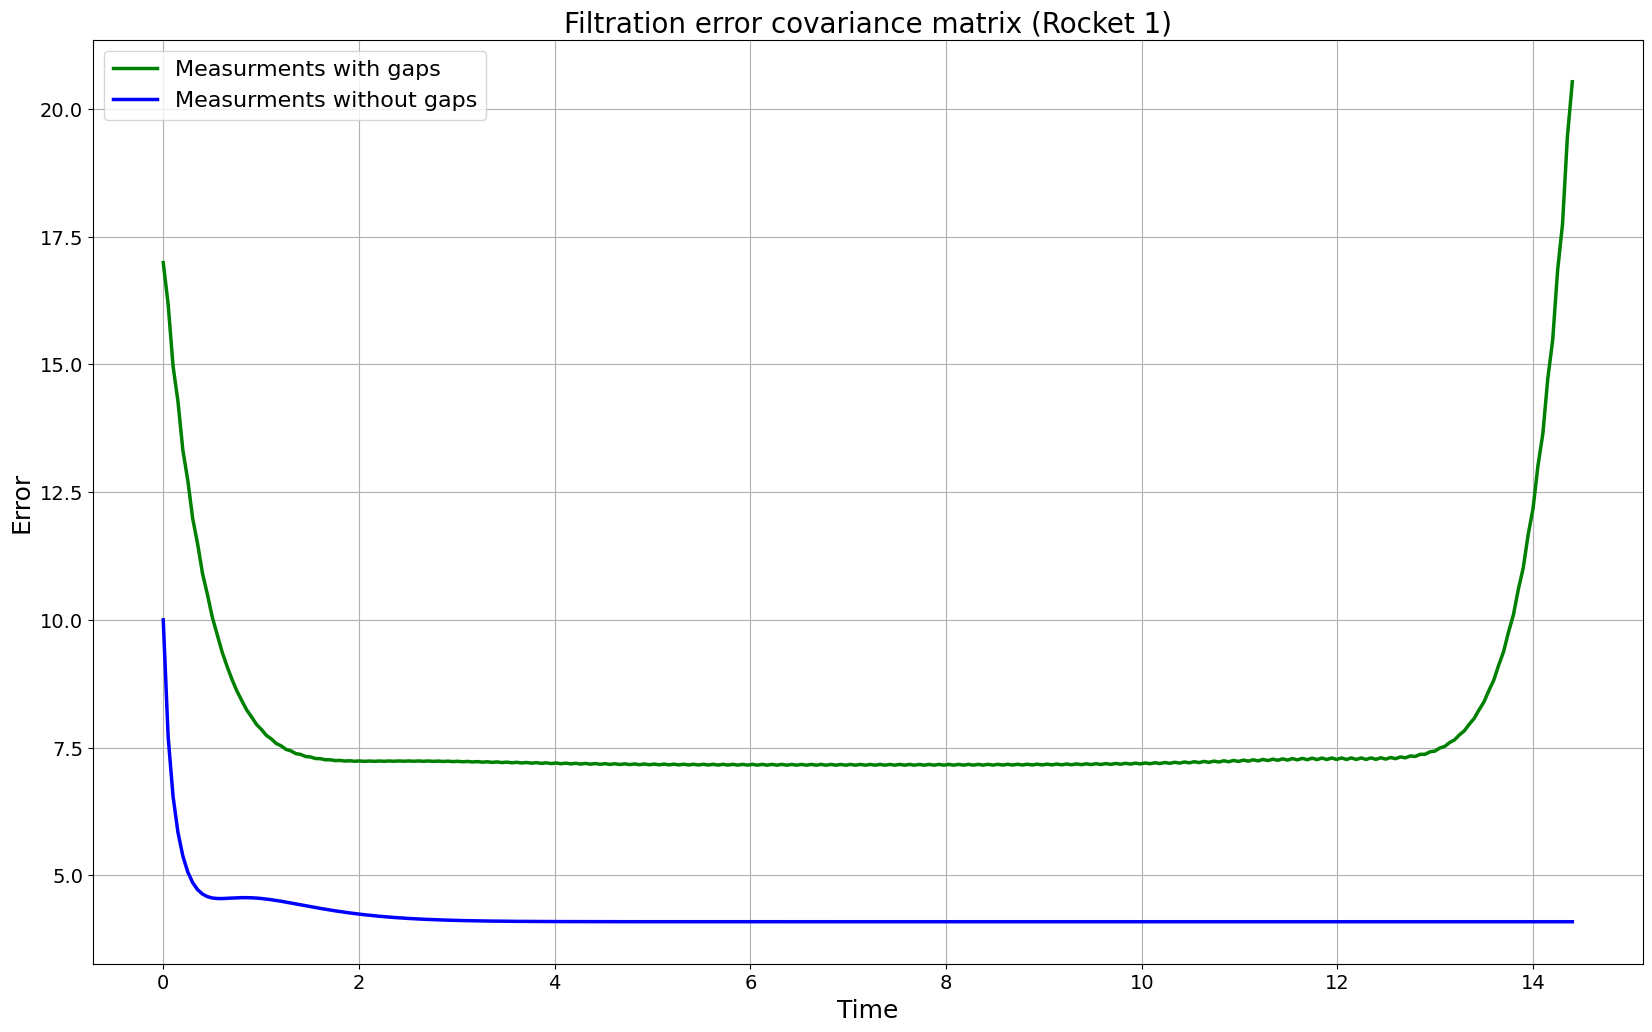

In [63]:
#Rocket P 1 with gaps and without 
fig, ax = plt.subplots(figsize=(20,12))
ax.set_title("Filtration error covariance matrix (Rocket 1)", fontsize = 20)
ax.set_ylabel("Error", fontsize = 18)
ax.set_xlabel("Time", fontsize = 18)
#ax.plot(Z_meas[0, :], 'b', alpha = 0.6, linewidth = 2, label = "Measurments")
ax.plot(time_1, P_back_1[0, 0, :], 'g', linewidth= 2.5, label = "Measurments with gaps")
ax.plot(time_1, oct_a[0, :], 'b', linewidth = 2.5, label = "Measurments without gaps")

ax.tick_params(labelsize = 14)
ax.legend(fontsize = 16)
ax.grid()
plt.show()

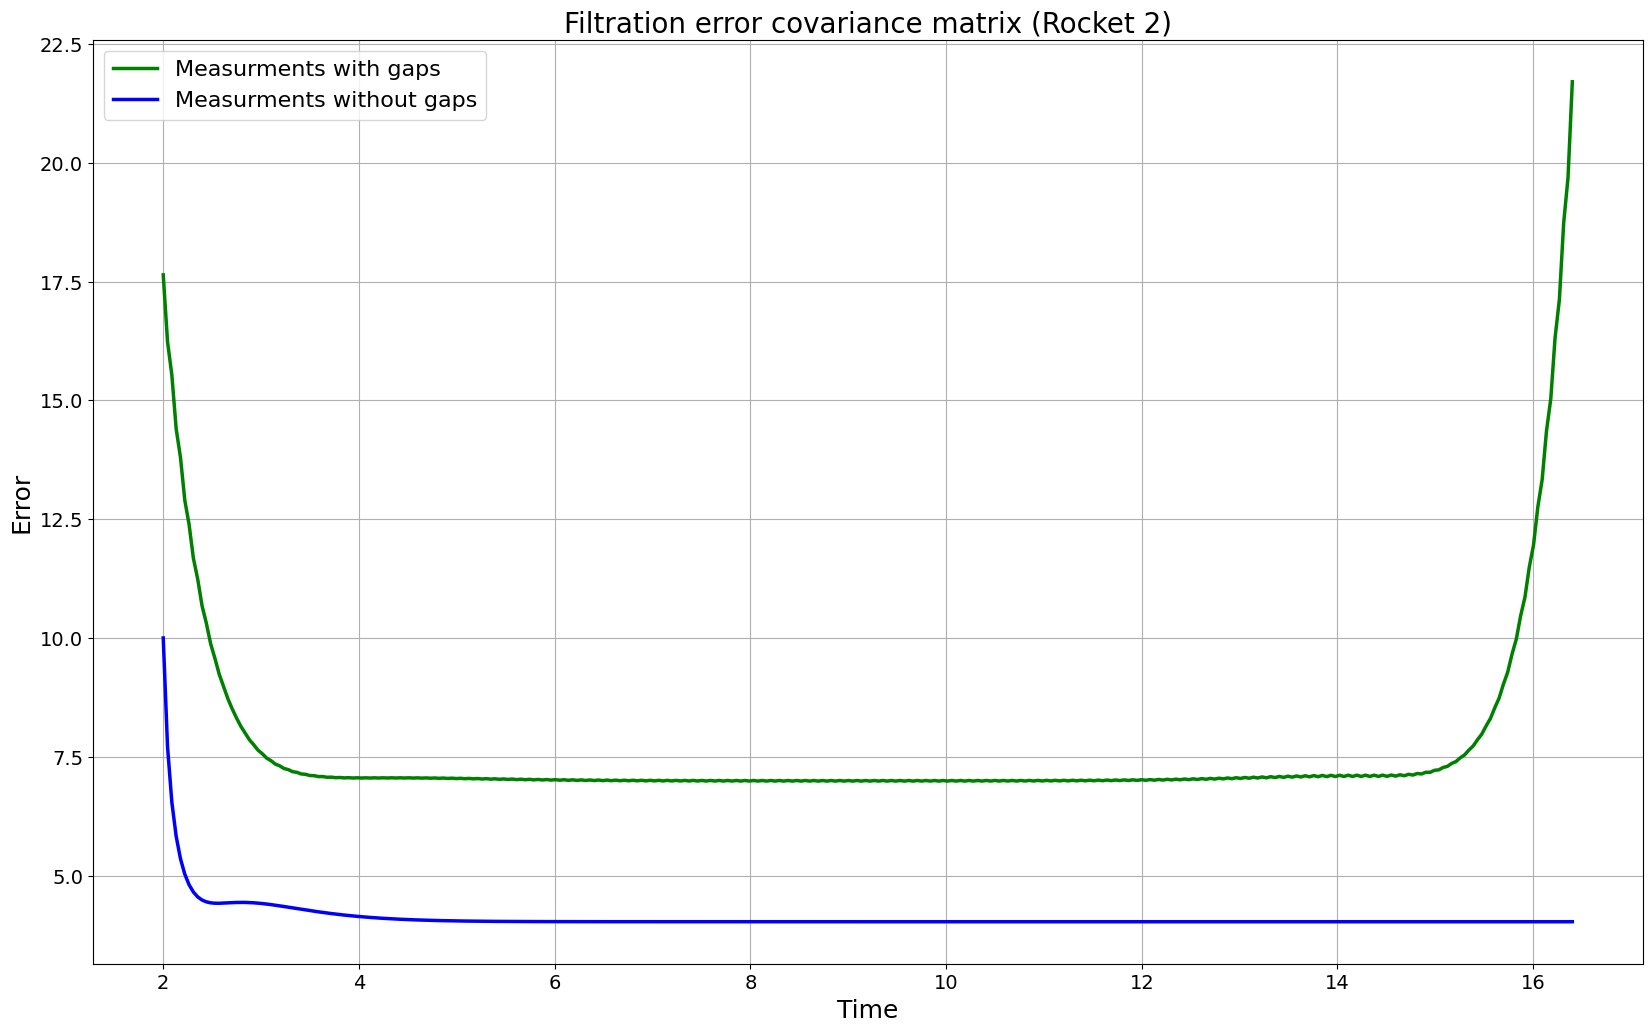

In [72]:
#Rocket P 2 with gaps and without (поменять данные для без геп)
fig, ax = plt.subplots(figsize=(20,12))
ax.set_title("Filtration error covariance matrix (Rocket 2)", fontsize = 20)
ax.set_ylabel("Error", fontsize = 18)
ax.set_xlabel("Time", fontsize = 18)
#ax.plot(Z_meas[0, :], 'b', alpha = 0.6, linewidth = 2, label = "Measurments")
ax.plot(time_2, P_back_2[0, 0, :], 'g', linewidth= 2.5, label = "Measurments with gaps")
ax.plot(time_2, oct_b, 'b', linewidth= 2.5, label = "Measurments without gaps")

ax.tick_params(labelsize = 14)
ax.legend(fontsize = 16)
ax.grid()
plt.show()

In [65]:
#Explousion point
line_1 = LineString(np.column_stack((time_1, X_back_1[0, :])))
line_2 = LineString(np.column_stack((time_2, X_back_2[0, :])))
intersection = line_1.intersection(line_2)
print(intersection.x, intersection.y)

5.791470528965092 239.19815359851526


In [66]:
""" fig, ax = plt.subplots(figsize=(15,7))
ax.set_title("Kalman hight estimations", fontsize = 16)
ax.set_ylabel("Position", fontsize = 14)
ax.set_xlabel("Observations", fontsize = 14)
#ax.plot(Z_meas[0, :], 'b', alpha = 0.6, linewidth = 2, label = "Measurments")
ax.plot(time_1, z_1[0, :], 'g.', linewidth=2, label = "Measured (1 rocket)")
#ax.plot(time_1, X_filt_1[0, :], 'r', linewidth = 2, label = "Kalman filtration (1 rocket)")
ax.plot(time_1, X_back_1[0, :], 'b', linewidth = 1.5, label = "Backward Kalman filtration (1 rocket)")

ax.plot(time_2, z_2[0, :], 'y.', linewidth=2, label = "Backward (2 rocket)")
#ax.plot(time_2, X_filt_2[0, :], 'b', linewidth = 2, label = "Kalman filtration (2 rocket)")
ax.plot(time_2, X_back_2[0, :], c = 'purple', linewidth = 1.5, label = "Backward Kalman filtration (2 rocket)")
ax.plot(*intersection.xy, 'ro', markersize = 10)

x_coord = intersection.x
x_axis = np.full((50, 1), x_coord)
ax.plot(x_axis, np.linspace(-50, 400), '--')
y_coord = intersection.y
y_axis = np.full((50, 1), y_coord)
ax.plot(np.linspace(-1, 20), y_axis, '--')

plt.xlim(-0.5, 17)
plt.ylim(-25, 360)

ax.tick_params(labelsize = 14)
ax.legend(fontsize = 10)
ax.grid()
plt.show() """

' fig, ax = plt.subplots(figsize=(15,7))\nax.set_title("Kalman hight estimations", fontsize = 16)\nax.set_ylabel("Position", fontsize = 14)\nax.set_xlabel("Observations", fontsize = 14)\n#ax.plot(Z_meas[0, :], \'b\', alpha = 0.6, linewidth = 2, label = "Measurments")\nax.plot(time_1, z_1[0, :], \'g.\', linewidth=2, label = "Measured (1 rocket)")\n#ax.plot(time_1, X_filt_1[0, :], \'r\', linewidth = 2, label = "Kalman filtration (1 rocket)")\nax.plot(time_1, X_back_1[0, :], \'b\', linewidth = 1.5, label = "Backward Kalman filtration (1 rocket)")\n\nax.plot(time_2, z_2[0, :], \'y.\', linewidth=2, label = "Backward (2 rocket)")\n#ax.plot(time_2, X_filt_2[0, :], \'b\', linewidth = 2, label = "Kalman filtration (2 rocket)")\nax.plot(time_2, X_back_2[0, :], c = \'purple\', linewidth = 1.5, label = "Backward Kalman filtration (2 rocket)")\nax.plot(*intersection.xy, \'ro\', markersize = 10)\n\nx_coord = intersection.x\nx_axis = np.full((50, 1), x_coord)\nax.plot(x_axis, np.linspace(-50, 400), \

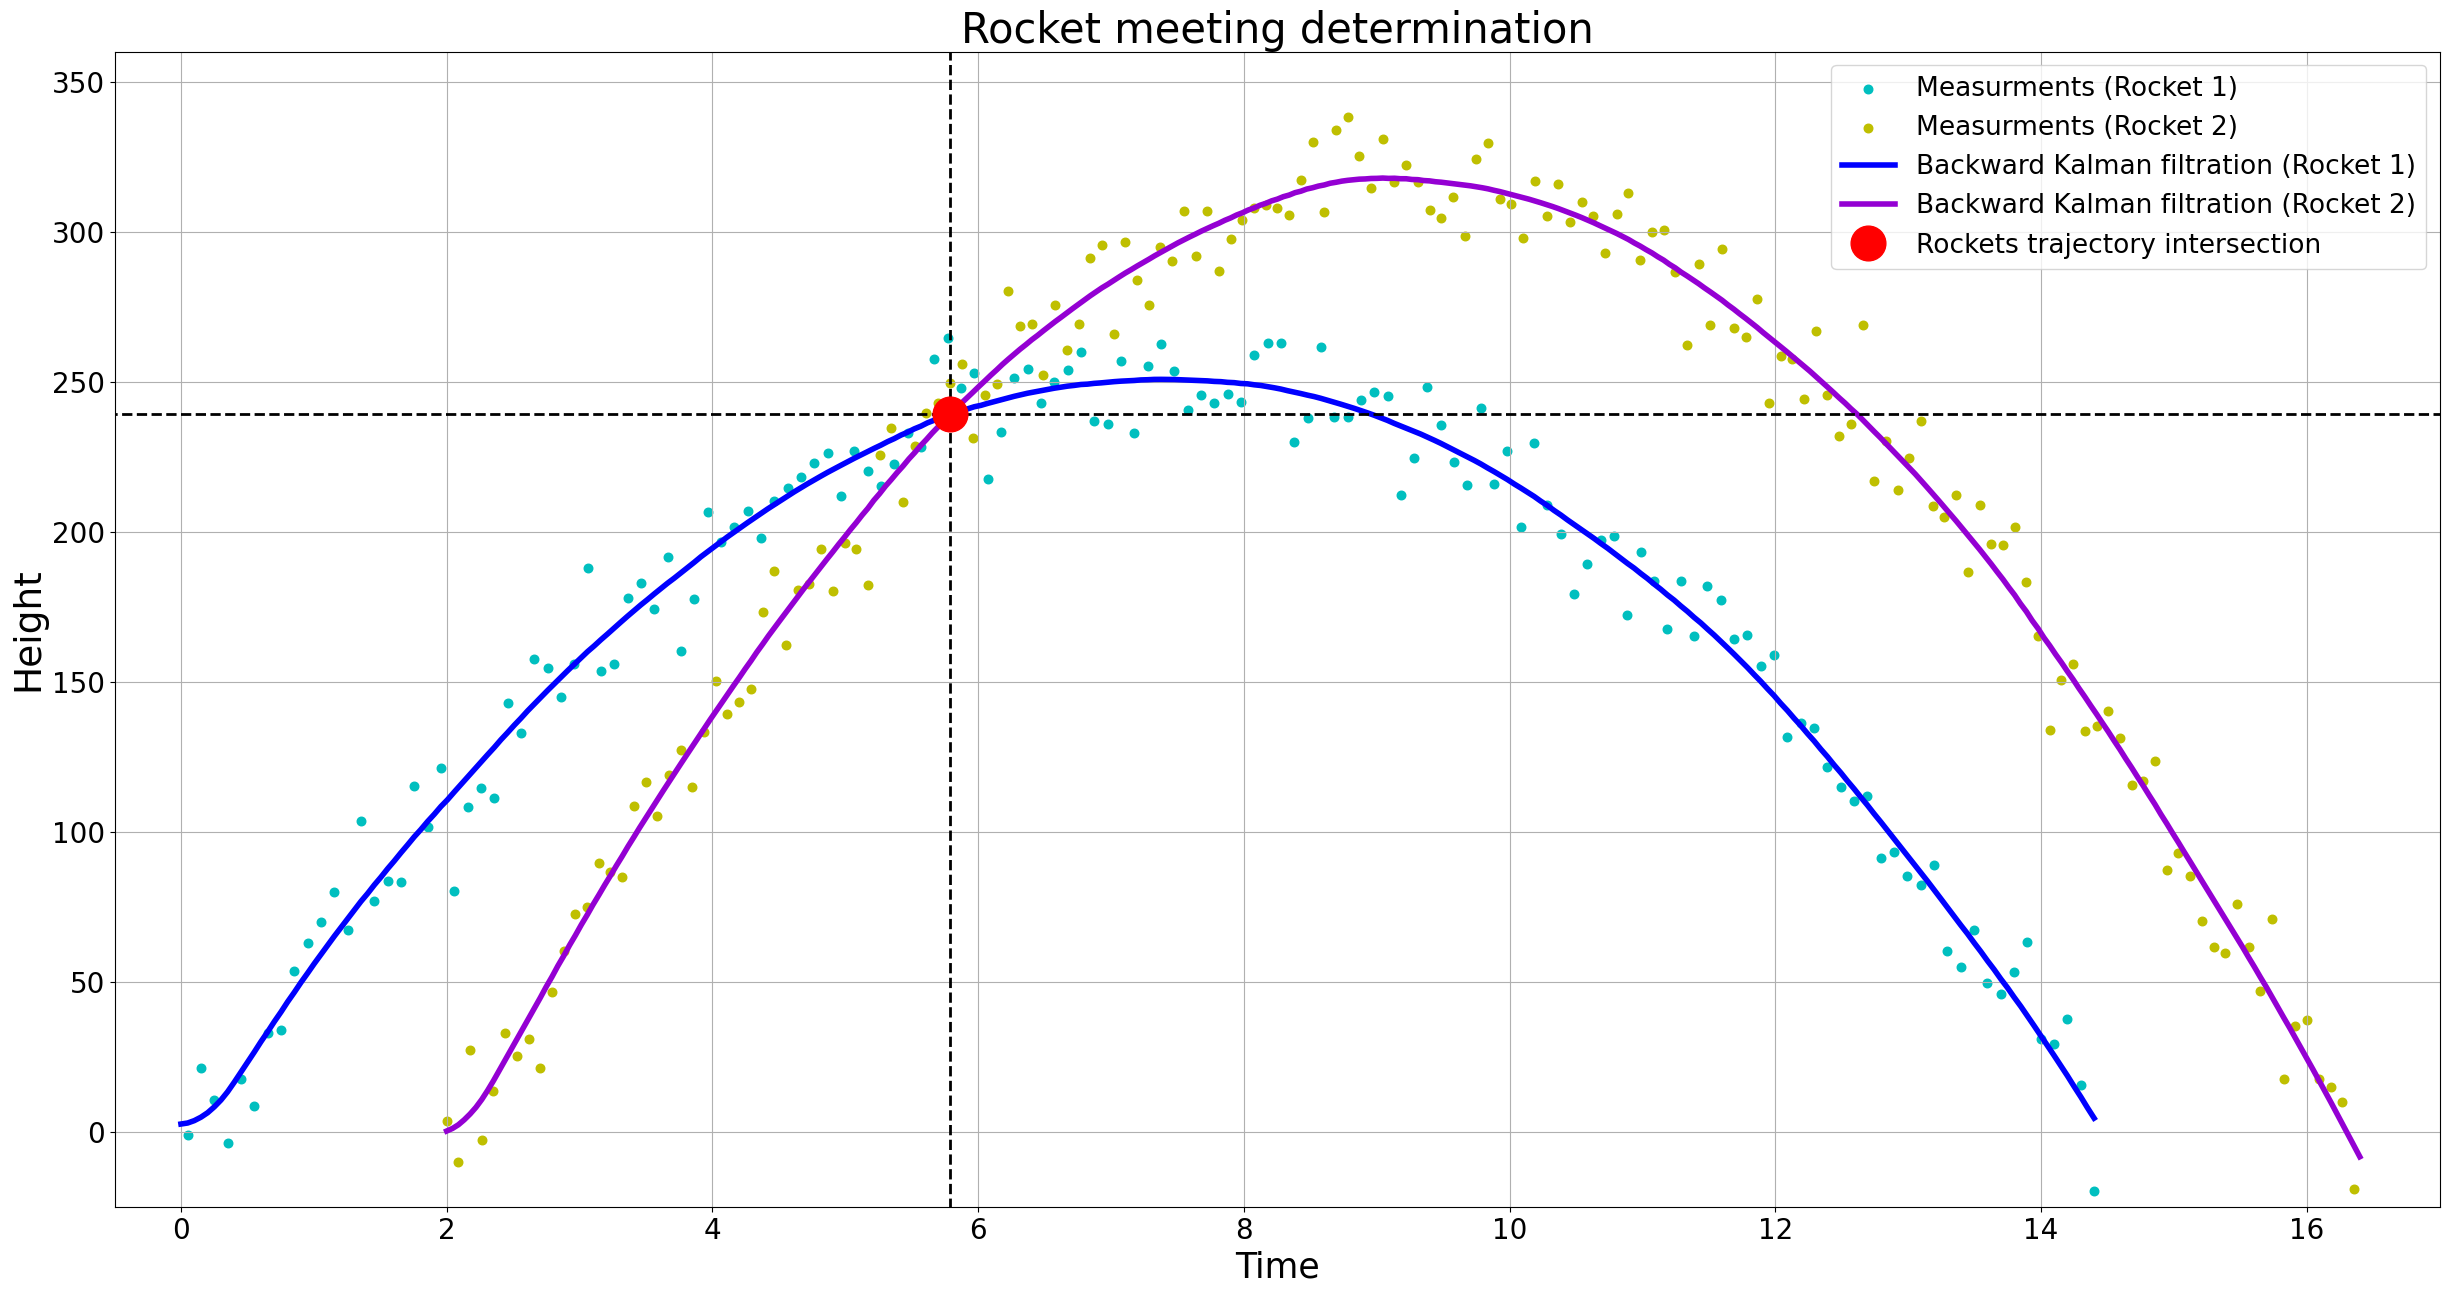

In [67]:
fig, ax = plt.subplots(figsize=(30,15))
ax.set_title("Rocket meeting determination", fontsize = 30)
ax.set_ylabel("Height", fontsize = 27)
ax.set_xlabel("Time", fontsize = 25)
ax.scatter(time_1, bar_1, c = 'c', s = 38, label = "Measurments (Rocket 1)")
ax.scatter(time_2, bar_2, c = 'y', s = 38, label = "Measurments (Rocket 2)")

ax.plot(time_1, X_back_1[0, :], 'b', linewidth = 4, label = "Backward Kalman filtration (Rocket 1)")
ax.plot(time_2, X_back_2[0, :], c = 'darkviolet', linewidth = 4, label = "Backward Kalman filtration (Rocket 2)")

x_coord = intersection.x
x_axis = np.full((50, 1), x_coord)
ax.plot(x_axis, np.linspace(-50, 400), 'k--', linewidth = 2)
y_coord = intersection.y
y_axis = np.full((50, 1), y_coord)
ax.plot(np.linspace(-1, 20), y_axis, 'k--', linewidth = 2)

ax.plot(*intersection.xy, 'ro', markersize = 25, label = 'Rockets trajectory intersection')

plt.xlim(-0.5, 17)
plt.ylim(-25, 360)

ax.tick_params(labelsize = 20)
ax.legend(fontsize = 19)
plt.grid()

In [68]:
#Functions with and without Q
def Kalman_Q__(X_init, P_init, Phi, size_, z_):
    #Filterd position
    X_pred = np.zeros((3, size_))
    P_pred = np.zeros((3, 3, size_))

    X_filt = np.zeros((3, size_))
    P_filt = np.zeros((3, 3, size_))
    
    K_ = np.zeros((3, 2, size_))

    X_filt[:, 0] = X_init[:, 0]
    print(X_filt[2, 0])
    P_filt[:, :, 0] = P_init

    H = np.array([[1, 0, 0], [0, 0, 1]])
    #Covariance matrix 𝑅 of measurements noise
    R = np.array([[sigma_s, 0], [0, sigma_a]])
    I = np.eye(3)

    for n in range(1, size_):
        if np.isnan(z_[0, n]) == True:
            X_pred[:, n] = (Phi.dot(X_filt[:, n-1].reshape(3, 1))).reshape(-1)
            P_pred[:, :, n] = (Phi.dot(P_filt[:, :, n-1])).dot(Phi.T)

            X_filt[:, n] = X_pred[:, n]
            P_filt[:, :, n] = P_pred[:, :, n]
        else:
            X_pred[:, n] = (Phi.dot(X_filt[:, n-1].reshape(3, 1))).reshape(-1)
            P_pred[:, :, n] = (Phi.dot(P_filt[:, :, n-1])).dot(Phi.T)

            K_[:, :, n] = np.dot(P_pred[:, :, n].dot(H.T), np.linalg.inv(H.dot(P_pred[:, :, n]).dot(H.T) + R))
            P_filt[:, :, n] = (I - K_[:, :, n].dot(H)).dot(P_pred[:, :, n])
            X_filt[:, n] = (X_pred[:, n].reshape(3, 1) + K_[:, :, n].dot(z_[:, n].reshape(2, 1) - H.dot(X_pred[:, n].reshape(3, 1)))).reshape(-1)

    return X_pred, P_pred, X_filt, P_filt, K_

In [69]:
X_pred_1_Q, P_pred_1_Q, X_filt_1_Q, P_filt_1_Q, K_1_Q = Kalman_Q__(X_init_1, P_init_1, Phi_1, Meas_1, z_1)
X_back_1_Q, P_back_1_Q = Kalman_backward(X_filt_1_Q, P_filt_1_Q, P_pred_1_Q, Phi_1, Meas_1)



160.0


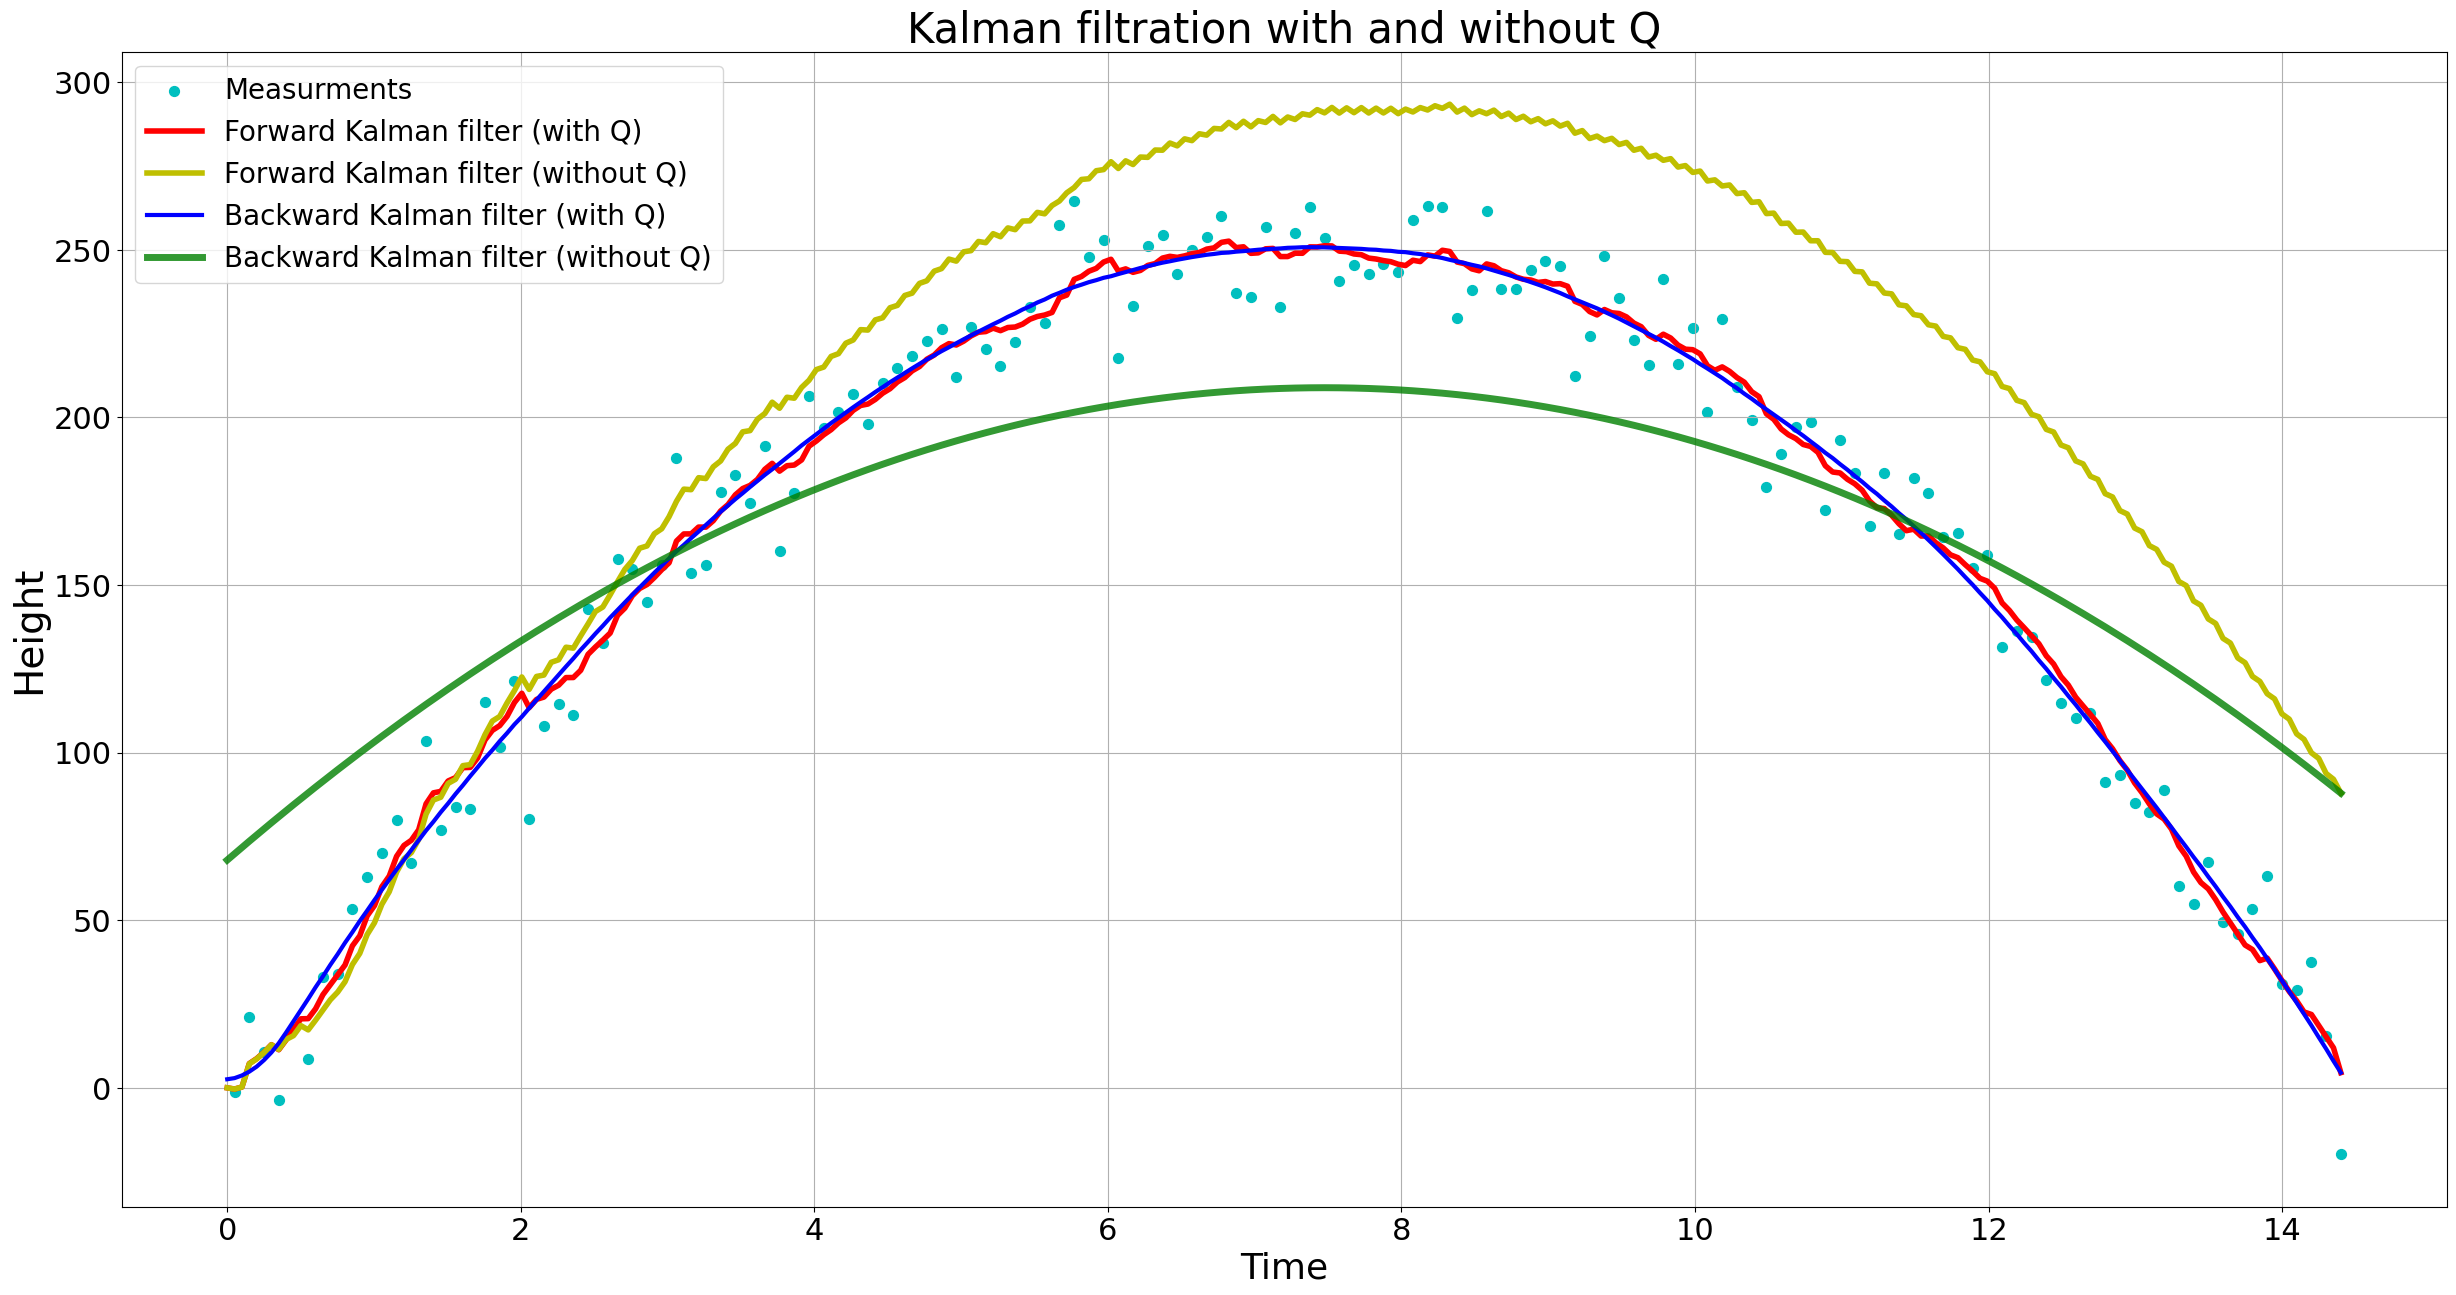

In [70]:
fig, ax = plt.subplots(figsize=(30,15))
ax.set_title("Kalman filtration with and without Q", fontsize = 30)
ax.set_ylabel("Height", fontsize = 28)
ax.set_xlabel("Time", fontsize = 26)
#ax.plot(Z_meas[0, :], 'b', alpha = 0.6, linewidth = 2, label = "Measurments")
ax.scatter(time_1, bar_1, c = 'c', s = 50, label = "Measurments")
ax.plot(time_1, X_filt_1[0, :], 'r', linewidth = 4, label = "Forward Kalman filter (with Q)")
ax.plot(time_1, X_filt_1_Q[0, :], 'y', linewidth = 4, label = "Forward Kalman filter (without Q)")


ax.plot(time_1, X_back_1[0, :], c = 'b', linewidth = 3, label = "Backward Kalman filter (with Q)")
ax.plot(time_1, X_back_1_Q[0, :], c = 'g', linewidth = 5, alpha = 0.8, label = "Backward Kalman filter (without Q)")

#ax.plot(time_2, X_filt_2[0, :], 'b', linewidth = 2, label = "Kalman filtration (2 rocket)")

ax.tick_params(labelsize = 22)
ax.legend(fontsize = 20)
ax.grid()
plt.show()